In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("../data/cleaned/final_merged_dataset.csv")
df.head()

,State,Crime_Type,Year,Cases,unemployment_rate,poverty_rate,per_capita_income,inflation_rate,population_density,gender_ratio,literacy_rate,youth_population_percent,urbanization_rate,human_development_index,police_stations_per_district,conviction_rate,police_personnel_per_100k,alcohol_consumption_per_capita
0,Andaman & Nicobar Islands,Burglary,2001,2818,5.88,38.54,21691.80,4.40,10,915,61.94,24.00,22.0,0.535,6,37.0,59,2.30
1,Andaman & Nicobar Islands,Burglary,2002,2402,4.80,37.61,22162.42,7.63,10,904,62.09,26.98,21.4,0.528,7,41.1,55,2.05
2,Andaman & Nicobar Islands,Burglary,2003,4155,5.75,36.41,22868.34,2.43,17,912,62.32,27.96,24.8,0.543,5,42.2,64,2.18
3,Andaman & Nicobar Islands,Burglary,2004,1299,5.98,37.11,23056.59,5.83,14,910,62.38,27.94,23.2,0.548,7,41.3,57,2.06
4,Andaman & Nicobar Islands,Burglary,2005,1873,5.70,35.07,23480.14,5.63,17,913,62.52,23.92,24.6,0.553,5,36.4,61,2.59


In [3]:
numerical_cols = [
    'Year', 'unemployment_rate', 'poverty_rate', 'per_capita_income',
    'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate',
    'youth_population_percent', 'urbanization_rate', 'human_development_index',
    'police_stations_per_district', 'conviction_rate',
    'police_personnel_per_100k', 'alcohol_consumption_per_capita'
]

categorical_cols = ['State', 'Crime_Type']

In [4]:
# Split data by Year (train / val / test)

# Separate features (X_raw) and target (y)

target = 'Cases'

features = [
    'State', 'Crime_Type', 'Year', 'unemployment_rate', 'poverty_rate', 'per_capita_income',
    'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate',
    'youth_population_percent', 'urbanization_rate', 'human_development_index',
    'police_stations_per_district', 'conviction_rate', 'police_personnel_per_100k',
    'alcohol_consumption_per_capita'
]

X_raw = df[features]
y = df[target]

# Split by Year

train_df = df[df['Year'] <= 2017]
val_df   = df[(df['Year'] > 2017) & (df['Year'] <= 2020)]
test_df  = df[df['Year'] > 2020]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Extract X and y for each split
X_train_raw = train_df[features]
y_train = train_df[target]

X_val_raw = val_df[features]
y_val = val_df[target]

X_test_raw = test_df[features]
y_test = test_df[target]

print("✅ Data successfully split")

Train shape: (5355, 18)
Validation shape: (945, 18)
Test shape: (630, 18)
✅ Data successfully split


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_cols),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit on training data and transform all splits
X_train = preprocessor.fit_transform(train_df[categorical_cols + numerical_cols])
X_val   = preprocessor.transform(val_df[categorical_cols + numerical_cols])
X_test  = preprocessor.transform(test_df[categorical_cols + numerical_cols])

print("One-Hot Encoding & Scaling Done!")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

One-Hot Encoding & Scaling Done!
Train shape: (5355, 59)
Validation shape: (945, 59)
Test shape: (630, 59)


In [6]:
import joblib
import numpy as np
import pandas as pd
from math import sqrt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [7]:
model = XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.25,
    max_depth = 8,
    random_state = 42,
    n_jobs=-1
)
model.fit(X_train, y_train)
y_pre = model.predict(X_train)
y_pred = model.predict(X_val)
y_predd = model.predict(X_test)

print("R2:", r2_score(y_train, y_pre))
print("RMSE:", sqrt(mean_squared_error(y_train, y_pre)))
print("MAE:", mean_absolute_error(y_train, y_pre))
print()

print("R2:", r2_score(y_val, y_pred))
print("RMSE:", sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print()

print("R2:", r2_score(y_test, y_predd))
print("RMSE:", sqrt(mean_squared_error(y_test, y_predd)))
print("MAE:", mean_absolute_error(y_test, y_predd))

R2: 0.9111713767051697
RMSE: 405.12802760362064
MAE: 302.7275085449219

R2: 0.41585493087768555
RMSE: 1033.9277054030422
MAE: 784.4531860351562

R2: 0.29567956924438477
RMSE: 1334.3759777513983
MAE: 1027.2955322265625


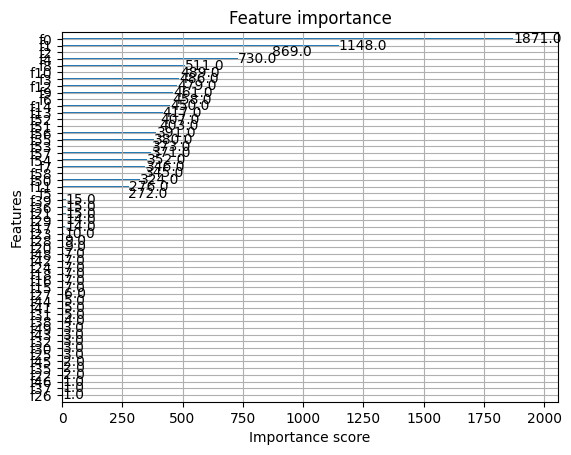

In [8]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.show()


In [9]:
trees = model.get_booster().get_dump()
len(trees)

100

In [10]:
print(trees[0])

0:[f11<0.192157075] yes=1,no=2,missing=2
	1:[f3<-1.02572286] yes=3,no=4,missing=4
		3:[f50<1] yes=7,no=8,missing=8
			7:[f4<0.762629807] yes=15,no=16,missing=16
				15:[f12<-1.66596413] yes=31,no=32,missing=32
					31:[f54<1] yes=63,no=64,missing=64
						63:[f52<1] yes=119,no=120,missing=120
							119:[f56<1] yes=215,no=216,missing=216
								215:leaf=-227.81488
								216:leaf=-4.11450195
							120:[f1<0.717987597] yes=217,no=218,missing=218
								217:leaf=-214.387085
								218:leaf=331.279572
						64:[f1<0.717987597] yes=121,no=122,missing=122
							121:leaf=-73.137085
							122:leaf=259.862915
					32:[f13<-0.259289563] yes=65,no=66,missing=66
						65:[f2<-0.517360628] yes=123,no=124,missing=124
							123:[f57<1] yes=219,no=220,missing=220
								219:leaf=272.775299
								220:leaf=-298.810486
							124:[f2<-0.25505513] yes=221,no=222,missing=222
								221:leaf=-80.987648
								222:leaf=73.6286545
						66:[f57<1] yes=125,no=126,missing=126
							125:[f9<-1.866

In [11]:
import joblib

joblib.dump(model, "../model/xgb_model.pkl")

['../model/xgb_model.pkl']